# Introduction

This notebook was originally written for the use of CapeCrystal laboratory at Cornell University. It showcases the software Signac, its uses in data management, and important Signac functions.

This notebook is best used in conjunction with tutorials and examples on the Signac documentation, which are much more complete

In [1]:
import signac
import numpy as np
import matplotlib.pyplot as pp

# Initializing a Project
This process would normally be done in the command line, but you can also do it in Python. Step one is to create a project, giving it a name that is descriptive for you. This will create a signac.rc file to store information about the project. This only needs to be done once.

In [2]:
project = signac.init_project()

You will then initialize jobs by setting their statepoints. There are a number of ways to do this depending on what exactly your data space looks like. In general, a "statepoint" should be a set of variables which uniquely identify each separate simulation, and which cannot be changed without fundamentally changing the experiment. For us, common statepoints include parameters for a pair potential, system size N, mole fraction of different particle types, and replica index.
You can initialize a job multiple times without changing it, so filling in gaps in a dataspace later is easy. You can always delete jobs or add more.

In [3]:
replicas = [1,2,3]
numbers = np.arange(4,8,1)

for r in replicas:
    for N in numbers:
        statepoint = {"N":N,
                     "replica":r}
        
        project.open_job(statepoint).init() 
        #all jobs must have something done to them in order to persist
        #this could be running init but it could also be something else like writing a file

/Users/rachaelskye/opt/anaconda3/envs/hoomd4/lib/python3.12/site-packages/synced_collections/numpy_utils.py:46: NumpyConversionWarning: Any numpy types provided will be transparently converted to the closest base Python equivalents.
  warnings.warn(NUMPY_CONVERSION_WARNING, NumpyConversionWarning)


(3.0, 8.0)

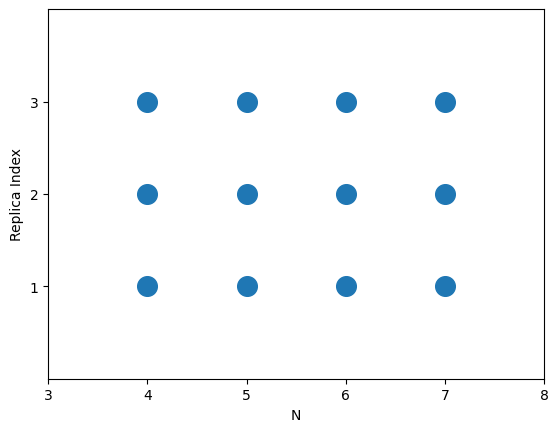

In [22]:
ns=[]
rs=[]
for job in project:
    ns.append(job.sp.N)
    rs.append(job.sp.replica)

pp.scatter(ns,rs, s=200)
pp.ylabel('Replica Index')
pp.xlabel('N')
pp.ylim(0,4)
pp.yticks([1,2,3])
pp.xlim(3,8)

Once initialized, a job is associated with an ID, which is a hash (basically, complex function) of the statepoint dictionary. One statepoint will always have one,identical ID. You cannot change one without changing the other.

In [4]:
job = project.open_job({"N":4,"replica":1})
print(job.id)

cdb4624cc6158e6b3a7100730baacb6a


The statepoint for a job can be accessed with the job.sp command.
Data associated with a job that is either 1) changeable, or 2) too complex to want in a statepoint can be written in the job document. A project can be iterated through like it is a list, though note that it won't be sorted.

In [5]:
for job in project:
    total_particles = job.sp.N ** 3
    job.document['total_particles'] = total_particles
    print(job.document['total_particles'])

343
125
64
216
216
343
64
125
125
216
343
64


After initializing a project, it can be loaded in using the get_project command:

Note that you can analyze more than one project at once by using the "root" command to specify the directory of each project, and giving them different names to reference

In [6]:
project = signac.get_project()
#different_project = signac.get_project(root='path_to_directory')

# Important Functions

In [7]:
#the open_job command only works if you input the full statepoint OR an ID
job = project.open_job({'N': 5, 'replica': 1})

#the isfile command returns whether or not a file exists for a specific job
#and is useful for checking completion
print(job.isfile('a_file.txt'))

False


In [8]:
#The fn or filename command preprends the path to the job's directory to any file
#it's critical for loading files for analysis
#And is part of why it's good to store files with the same name across all jobs

print(job.fn('a_file.example'))

/Users/rachaelskye/Documents/outreach/icomse/7th_workshop_MD/day_five/Advanced_Topics/data_management/workspace/5eb7a794973dd7f060d00aed3cfb364a/a_file.example


Finally, update_statepoint and reset_statepoint let you change the job statepoint. Do NOT do this manually. The job's signac_statepoint.json file and the job id/directory name are linked by what's called a hash. It lets Signac quickly sort and access jobs.  Changing either the file or the directory name manually will corrupt the job. See the documentation for advice on using these functions.

# Visualizing the data space

The "schema" command prints out what statepoints are available:

In [9]:
print(project.detect_schema())

{
 'N': 'int([4, 5, 6, 7], 4)',
 'replica': 'int([1, 2, 3], 3)',
}


It can also be useful to visualize which data points have been run if you are doing a parameter sweep:

And check which are done:

Text(0.5, 0, 'N')

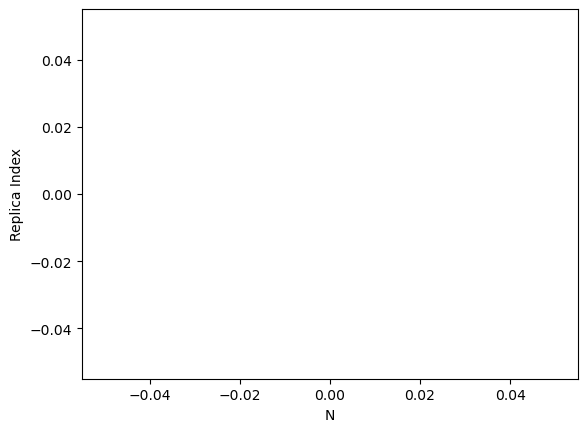

In [11]:
ns=[]
rs=[]
for job in project:
    if job.isfile('post_condition_file.txt'):
        ns.append(job.sp.N)
        rs.append(job.sp.replica)

pp.scatter(ns,rs, s=200)
pp.ylabel('Replica Index')
pp.xlabel('N')

# Find_jobs

find_jobs is the most basic command for searching your project. You can input a partial statepoint, and it will output an iterable list of all the jobs that match that statepoint. Find_jobs is *unordered*, you cannot ensure that the jobs will be sorted in a specific way.

In [12]:
for job in project.find_jobs({"N":5}):
    total_particles = job.document['total_particles']
    print(total_particles)

125
125
125


You can also use specialized syntax to apply logic, e.g. all jobs with a statepoint greater than a certain value. Key options are lte (less than or equal to), lt (less than) and corresponding gte and gt.

In [13]:
for job in project.find_jobs({"N":{'$gte':5}}):
    total_particles = job.document['total_particles']
    print(total_particles)

125
343
343
216
216
125
216
125
343


# groupby

GroupBy is one of the most useful commands for basic analysis. It sorts a statepoint internally (usually numerically, low to high) and outputs an iterable "dictionary" with the *key* it sorted by and the *value*, a list of jobs that correspond to that key.

You can group by multiple parameters by inputting lists.

In [14]:
for key, value in project.groupby("N"):
        print("N=",key, "has ", len(list(value))," jobs.")

N= 4 has  3  jobs.
N= 5 has  3  jobs.
N= 6 has  3  jobs.
N= 7 has  3  jobs.


In [23]:
for key, joblist in project.groupby(["N","replica"]):
        print("N is ", key[0], "replica is ", key[1])

N is  4 replica is  1
N is  4 replica is  2
N is  4 replica is  3
N is  5 replica is  1
N is  5 replica is  2
N is  5 replica is  3
N is  6 replica is  1
N is  6 replica is  2
N is  6 replica is  3
N is  7 replica is  1
N is  7 replica is  2
N is  7 replica is  3


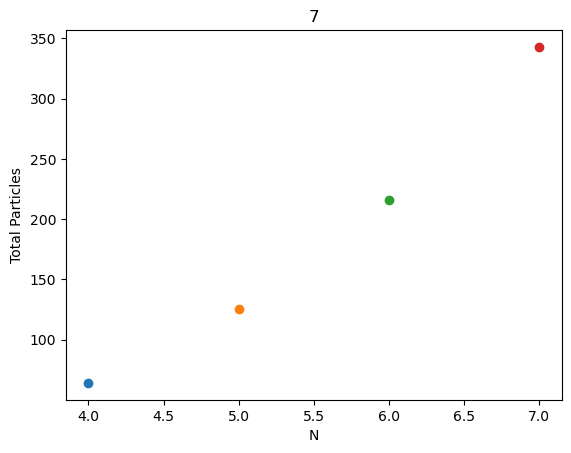

In [16]:
for key, joblist in project.groupby("N"):
        number_particles = []
        for job in joblist:
            data = job.document['total_particles']
            number_particles.append(data)
        
        mean_particles = np.mean(number_particles)
        
        pp.scatter([key], mean_particles)
        pp.ylabel('Total Particles')
        pp.xlabel('N')
        
        pp.title(str(key))

# Making subsets of projects

I find it useful to be able to make a subset of jobs and then group it. The object returned by find_jobs() has exactly the same properties as a project, so any sorting you apply to a project can also be applied to find_jobs. This lets you choose one or more statepoints to limit your project to, and then sort according to the remaining statepoints.

In [17]:
subset = project.find_jobs({"replica":3})

for key, joblist in subset.groupby({"N"}):
    for job in joblist:
        print(job.sp)

{'N': 4, 'replica': 3}
{'N': 5, 'replica': 3}
{'N': 6, 'replica': 3}
{'N': 7, 'replica': 3}
